# Aksacarma Machine Learning
This notebook run on Google Colab with Python 3.10.12, Tensorflow 2.12.0, and Keras 2.12.0

In [1]:
# Run this cell to check Python version
!python --version

Python 3.10.12


In [2]:
# Run this cell to check Tensorflow version
import tensorflow as tf
print(tf.__version__)

2.12.0


In [3]:
# Run this cell to check Keras version
import keras
print(keras.__version__)

2.12.0


## Get The Data
The data to be used is **Dermnet**, obtained from https://www.kaggle.com/datasets/shubhamgoel27/dermnet.

This section only needs to be run once.
This section will download the data from kaggle and standardize the dataset folder name.

In [4]:
# opendatasets is a Python library for downloading datasets from online sources like Kaggle.
# Follow this link for details, https://pypi.org/project/opendatasets/
%pip install opendatasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Import Required Libraries

In [5]:
# Import required libraries
import opendatasets as od
import os
import shutil
from shutil import copyfile
import random

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop
from tensorflow import keras

import matplotlib.pyplot as plt # matplotlib 3.7.1

### Download Dataset

In [6]:
# Run this cell to download dataset
dataset_url = "https://www.kaggle.com/datasets/shubhamgoel27/dermnet"
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: fawwazmts
Your Kaggle Key: ··········


100%|██████████| 1.72G/1.72G [00:21<00:00, 87.9MB/s]


In [7]:
# Define the Dermnet dataset path
source_dir = "./dermnet"
source_dir_train = os.path.join(source_dir, "train")
source_dir_test = os.path.join(source_dir, "test")

 ### Standardize The Dataset Folder Name

In [8]:
# Standariz name folder
# This cell will remove word "Photos" and change " " with "-"
def standerize_name(fn):
  fn = fn.lower().replace("photos", "")
  fn = " ".join(fn.split())
  return fn.replace(" ", "-")

In [11]:
# Correct all name folder with standariz name folder in main folder
def correct_name(main_folder_dir):
  old_dir_list = os.listdir(main_folder_dir)
  new_dir_list = [standerize_name(fn) for fn in old_dir_list]
  for i in range(len(old_dir_list)):
    old_name = os.path.join(main_folder_dir, old_dir_list[i])
    new_name = os.path.join(main_folder_dir, new_dir_list[i])
    os.rename(old_name, new_name)


In [12]:
# Correct folder name in "./dermnet/train" and "./dermnet/test"
correct_name(source_dir_train)
correct_name(source_dir_test)

After downloading and standardizing the folder name, the data will be merged and sorted manually for model training needs. In this Dermnet dataset irrelevant data will be deleted, for example non-skin images and microscopy images. The merged and sorted data can be accessed at the following [link](https://).

## Split Dataset
Split [merged dataset](https://) to train, validation, and test dataset. Data will be stored on Google Drive.

In [13]:
# Data access on google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [58]:
# Define directory
# source_path is the path where source data is fetched
source_path = "/content/drive/MyDrive/Colab Notebooks/merged-sorted-dermnet"
# Data from source_path will be separated and stored in root_dir
root_dir = './dermnet-image-for-train'

In [59]:
# From Dermnet dataset, 10 skin diseases were selected to make the model machine learning.
# Those are acne-and-rosacea, bullous-disease, eczema,
# melanoma-skin-cancer-nevi-and-moles,
# scabies-lyme-disease-and-other-infestations-and-bites,
# tinea-ringworm-candidiasis-and-other-fungal-infections, urticaria-hives,
# vascular-tumors, vasculitis, warts-molluscum-and-other-viral-infections
skin_type_desease = [
    'acne-and-rosacea',
    'bullous-disease',
    'eczema',
    'melanoma-skin-cancer-nevi-and-moles',
    'scabies-lyme-disease-and-other-infestations-and-bites',
    'tinea-ringworm-candidiasis-and-other-fungal-infections',
    'urticaria-hives',
    'vascular-tumors',
    'vasculitis',
    'warts-molluscum-and-other-viral-infections',
    ]

# n is many of types of skin desease
n = len(skin_type_desease)
print("Many of types of skin desease:", n)

Many of types of skin desease: 10


In [60]:
# Deletes all non-image files
!find ./merged-sorted-dermnet/ -type f ! -name "*.jpg" -exec rm {} +

# Check how many pictures are in the folder
for fn in skin_type_desease:
    source_path_skin = os.path.join(source_path, fn)
    print(f"There are {len(os.listdir(source_path_skin))} images of {fn}.")

find: ‘./merged-sorted-dermnet/’: No such file or directory
There are 870 images of acne-and-rosacea.
There are 544 images of bullous-disease.
There are 1537 images of eczema.
There are 542 images of melanoma-skin-cancer-nevi-and-moles.
There are 494 images of scabies-lyme-disease-and-other-infestations-and-bites.
There are 1542 images of tinea-ringworm-candidiasis-and-other-fungal-infections.
There are 265 images of urticaria-hives.
There are 602 images of vascular-tumors.
There are 513 images of vasculitis.
There are 1346 images of warts-molluscum-and-other-viral-infections.


In [61]:
# Empty directory to prevent FileExistsError is the function is run several times
if os.path.exists(root_dir):
    shutil.rmtree(root_dir)

In [62]:
# Create train and validation folder
def create_train_val_dirs(root_path, type_distribution):
  train_dir = os.path.join(root_path, 'train')
  validation_dir = os.path.join(root_path, 'validation')
  test_dir = os.path.join(root_path, 'test')

  # Create train's folder
  for fn in type_distribution:
    train_type_distribution_dir = os.path.join(train_dir, fn)
    os.makedirs(train_type_distribution_dir)

  # Create validation's folder
  for fn in type_distribution:
    validation_type_distribution_dir = os.path.join(validation_dir, fn)
    os.makedirs(validation_type_distribution_dir)

  # Create test's folder
  for fn in type_distribution:
    test_type_distribution_dir = os.path.join(test_dir, fn)
    os.makedirs(test_type_distribution_dir)


In [63]:
# Test create_train_val_dirs function
try:
  create_train_val_dirs(root_path=root_dir, type_distribution=skin_type_desease)
except FileExistsError:
  print("You should not be seeing this since the upper directory is removed beforehand")

for rootdir, dirs, files in os.walk(root_dir):
    for subdir in dirs:
        print(os.path.join(rootdir, subdir))

./dermnet-image-for-train/validation
./dermnet-image-for-train/test
./dermnet-image-for-train/train
./dermnet-image-for-train/validation/acne-and-rosacea
./dermnet-image-for-train/validation/vasculitis
./dermnet-image-for-train/validation/melanoma-skin-cancer-nevi-and-moles
./dermnet-image-for-train/validation/tinea-ringworm-candidiasis-and-other-fungal-infections
./dermnet-image-for-train/validation/warts-molluscum-and-other-viral-infections
./dermnet-image-for-train/validation/urticaria-hives
./dermnet-image-for-train/validation/bullous-disease
./dermnet-image-for-train/validation/eczema
./dermnet-image-for-train/validation/scabies-lyme-disease-and-other-infestations-and-bites
./dermnet-image-for-train/validation/vascular-tumors
./dermnet-image-for-train/test/acne-and-rosacea
./dermnet-image-for-train/test/vasculitis
./dermnet-image-for-train/test/melanoma-skin-cancer-nevi-and-moles
./dermnet-image-for-train/test/tinea-ringworm-candidiasis-and-other-fungal-infections
./dermnet-image-

In [64]:
# Split source data to training and validation data
def split_data(SOURCE_DIR, TRAINING_DIR, VALIDATION_DIR, TEST_DIR, SPLIT_SIZE):
  files = []
  for fn in os.listdir(SOURCE_DIR):
    file_path = os.path.join(SOURCE_DIR, fn)

    if os.path.getsize(file_path):
      files.append(fn)
    else:
      print(f"{fn} is zero length, so ignoring.")

  file_size = len(files)

  split_point_1 = int(file_size * SPLIT_SIZE[0])
  split_point_2 = int(file_size * SPLIT_SIZE[1]) + split_point_1

  shuffled = random.sample(files, file_size)

  train_set = shuffled[:split_point_1]
  validation_set = shuffled[split_point_1:split_point_2]
  test_set = shuffled[split_point_2:]

  for fn in train_set:
    copyfile(os.path.join(SOURCE_DIR, fn), os.path.join(TRAINING_DIR, fn))

  for fn in validation_set:
    copyfile(os.path.join(SOURCE_DIR, fn), os.path.join(VALIDATION_DIR, fn))

  for fn in test_set:
    copyfile(os.path.join(SOURCE_DIR, fn), os.path.join(TEST_DIR, fn))


In [65]:
# Process split skin desease data
# Define training and validation root
TRAINING_DIR = os.path.join(root_dir, "train")
VALIDATION_DIR = os.path.join(root_dir, "validation")
TEST_DIR = os.path.join(root_dir, "test")

In [66]:
# List of all skin disease source directory
SKIN_TYPE_DIR_SOURCE = []
# List of all skin disease training directory
SKIN_TYPE_DIR_TRAINING = []
# List of all skin disease calidation directory
SKIN_TYPE_DIR_VALIDATION = []
# List of all skin disease test directory
SKIN_TYPE_DIR_TEST = []

# Append list of SKIN_TYPE_DIR_SOURCE, SKIN_TYPE_DIR_TRAINING, SKIN_TYPE_DIR_VALIDATION
for fn in skin_type_desease:
  SKIN_SOURCE_DIR = f"{source_path}/{fn}"
  SKIN_TYPE_DIR_SOURCE.append(SKIN_SOURCE_DIR)

  TRAINING_SKIN_DIR = os.path.join(TRAINING_DIR, fn)
  SKIN_TYPE_DIR_TRAINING.append(TRAINING_SKIN_DIR)

  VALIDATION_SKIN_DIR = os.path.join(VALIDATION_DIR, fn)
  SKIN_TYPE_DIR_VALIDATION.append(VALIDATION_SKIN_DIR)

  TEST_SKIN_DIR = os.path.join(TEST_DIR, fn)
  SKIN_TYPE_DIR_TEST.append(TEST_SKIN_DIR)

# Empty directories in case this cell run multiple times
for fn in SKIN_TYPE_DIR_TRAINING:
  if len(os.listdir(fn)) > 0:
    for file in os.scandir(fn):
      os.remove(file.path)

for fn in SKIN_TYPE_DIR_VALIDATION:
  if len(os.listdir(fn)) > 0:
    for file in os.scandir(fn):
      os.remove(file.path)

for fn in SKIN_TYPE_DIR_TEST:
  if len(os.listdir(fn)) > 0:
    for file in os.scandir(fn):
      os.remove(file.path)

# Define proportion of images used for training, validation, and test
# (training proportion, validation proportion), remainder is test set
split_size = (.8, .15) # 80% for training, 15% for validation, and rest 5% for test

# Split from source folder to training and validation folder
for i in range(len(skin_type_desease)):
  TMP_SOURCE_DIR = SKIN_TYPE_DIR_SOURCE[i]
  TMP_TRAINING_DIR = SKIN_TYPE_DIR_TRAINING[i]
  TMP_VALIDATION_DIR = SKIN_TYPE_DIR_VALIDATION[i]
  TMP_TEST_DIR = SKIN_TYPE_DIR_TEST[i]

  split_data(TMP_SOURCE_DIR, TMP_TRAINING_DIR, TMP_VALIDATION_DIR, TMP_TEST_DIR, split_size)

# Check that the number of images matches the expected output
print("The number of images in folder Original -> Training, Validation, Test")
for i in range(len(skin_type_desease)):
  print(f"{skin_type_desease[i]} : {len(os.listdir(SKIN_TYPE_DIR_SOURCE[i]))} -> {len(os.listdir(SKIN_TYPE_DIR_TRAINING[i]))}, {len(os.listdir(SKIN_TYPE_DIR_VALIDATION[i]))}, {len(os.listdir(SKIN_TYPE_DIR_TEST[i]))}")

The number of images in folder Original -> Training, Validation, Test
acne-and-rosacea : 870 -> 696, 130, 44
bullous-disease : 544 -> 435, 81, 28
eczema : 1537 -> 1229, 230, 78
melanoma-skin-cancer-nevi-and-moles : 542 -> 433, 81, 28
scabies-lyme-disease-and-other-infestations-and-bites : 494 -> 395, 74, 25
tinea-ringworm-candidiasis-and-other-fungal-infections : 1542 -> 1233, 231, 78
urticaria-hives : 265 -> 212, 39, 14
vascular-tumors : 602 -> 481, 90, 31
vasculitis : 513 -> 410, 76, 27
warts-molluscum-and-other-viral-infections : 1346 -> 1076, 201, 69


## Create Model

In [67]:
# Define batch size
BATCH_SIZE = 32

### Image Augmentation

In [68]:
# Creates the training and validation data generators
train_datagen = ImageDataGenerator(rescale = 1.0/255.,
                                   rotation_range = 40,
                                   zoom_range = 0.2,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   horizontal_flip = True,
                                   vertical_flip = True,
                                   )
train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                      batch_size=BATCH_SIZE,
                                                      class_mode='categorical',
                                                      target_size=(150, 150)
                                                      )

validation_datagen = ImageDataGenerator(rescale = 1.0/255.,
                                        rotation_range = 40,
                                        zoom_range = 0.2,
                                        width_shift_range = 0.2,
                                        height_shift_range = 0.2,
                                        horizontal_flip = True,
                                        vertical_flip = True,
                                        )
validation_generator = validation_datagen.flow_from_directory(directory=TEST_DIR,
                                                              batch_size=BATCH_SIZE,
                                                              class_mode='categorical',
                                                              target_size=(150, 150)
                                                              )

Found 6600 images belonging to 10 classes.
Found 422 images belonging to 10 classes.


In [69]:
# Define step size for train and validation
STEP_SIZE_TRAIN = (train_generator.n // train_generator.batch_size)
STEP_SIZE_VALID = (validation_generator.n // validation_generator.batch_size)

### Import Transfer Learning InceptionV3



In [32]:
# Download the pre-trained weights. No top means it excludes the fully connected layer it uses for classification.
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2023-06-15 15:47:20--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.141.128, 142.250.101.128, 142.251.2.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.141.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   212MB/s    in 0.4s    

2023-06-15 15:47:21 (212 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [33]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers

# Set the downloaded weights file into a variable
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

# Initialize the base model.
# Set the input shape and remove the dense layers.
pre_trained_model = InceptionV3(input_shape = (150, 150, 3),
                                include_top = False,
                                weights = None)

# Load the pre-trained weights you downloaded.
pre_trained_model.load_weights(local_weights_file)

# Freeze the weights of the layers.
for layer in pre_trained_model.layers:
  layer.trainable = False

In [34]:
# Choose `mixed_7` as the last layer of base model
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


### Define Model And Train Model

In [35]:
from tensorflow.keras import Model

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(n, activation='softmax')(x)

# Append the dense network to the base model
model = Model(pre_trained_model.input, x)

# Print the model summary. See dense network connected at the end.
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

In [70]:
# !!! ATTENTION !!!
# Load Saved_Model
# this cell is executed if colab suddenly stops. The model is trained from the saved model that saved before.
model_path = "/content/saved_model/ml-aksacarma"
model = tf.keras.models.load_model(model_path)

In [71]:
# Config the model with optimizer, losses, and metrics
model.compile(
    optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001),
    loss = "categorical_crossentropy",
    metrics = ['acc']
    )

In [72]:
# Train the model
# It can reach -> loss: 0.6811 - acc: 0.7690 - val_loss: 1.4539 - val_acc: 0.6322 in 8 × 15 epochs
history = model.fit(
    train_generator,
    validation_data = validation_generator,
    steps_per_epoch = STEP_SIZE_TRAIN,
    epochs = 5,
    validation_steps = STEP_SIZE_VALID,
    )

Epoch 1/5
206/206 [==============================] - 356s 2s/step - loss: 0.7923 - acc: 0.7416 - val_loss: 0.7283 - val_acc: 0.7404
Epoch 2/5
206/206 [==============================] - 378s 2s/step - loss: 0.7639 - acc: 0.7468 - val_loss: 0.7676 - val_acc: 0.7380
Epoch 3/5
206/206 [==============================] - 352s 2s/step - loss: 0.7576 - acc: 0.7482 - val_loss: 0.7056 - val_acc: 0.7885
Epoch 4/5
206/206 [==============================] - 359s 2s/step - loss: 0.7570 - acc: 0.7485 - val_loss: 0.8067 - val_acc: 0.7572
Epoch 5/5
206/206 [==============================] - 356s 2s/step - loss: 0.7502 - acc: 0.7529 - val_loss: 0.7477 - val_acc: 0.7500


### Plot Training Accuracy and Lose

In [73]:
# Plot result training and validation data

# Retrieve a list of list results on training and test data sets for each training epoch
def plot_acc_loss(history_model, metric):
    if metric == "acc":
        acc = history_model.history['acc']
        val_acc = history_model.history['val_acc']
    elif metric == "accuracy":
        acc = history_model.history['accuracy']
        val_acc = history_model.history['val_accuracy']

    loss = history_model.history['loss']
    val_loss = history_model.history['val_loss']

    epochs = range(len(acc)) # Get number of epochs

    # Plot training and validation accuracy per epoch
    plt.plot(epochs, acc, 'r', label="Training Accuracy")
    plt.plot(epochs, val_acc, 'b', label="Validation Accuracy")
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    # Plot training and validation loss per epoch
    plt.plot(epochs, loss, 'r', label="Training Loss")
    plt.plot(epochs, val_loss, 'b', label="Validation Loss")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

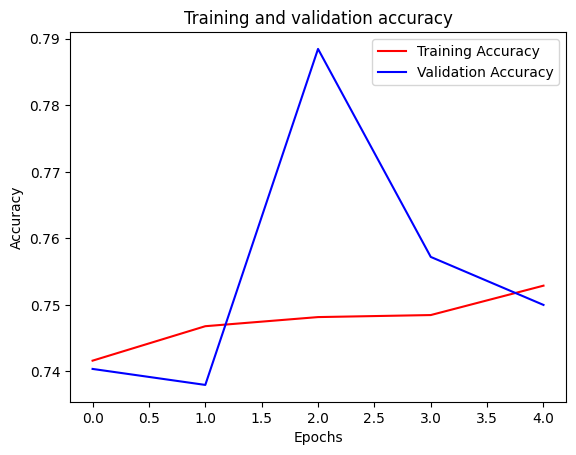

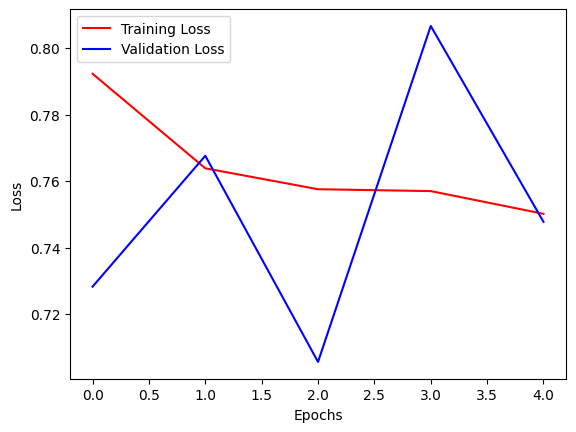

In [74]:
plot_acc_loss(history, "acc")

## Export Model
After the model is trained, save the model

In [75]:
# Export model to SavedModel, HDF5 Format
!mkdir -p saved_model
model.save('saved_model/ml-aksacarma-1')

In [77]:
# For Google Colab, run this cell to convert the model to zip and download it
from google.colab import files
!zip -r savedmodel-1.zip "/content/saved_model/ml-aksacarma-1"
files.download("/content/savedmodel-1.zip")

  adding: content/saved_model/ml-aksacarma-1/ (stored 0%)
  adding: content/saved_model/ml-aksacarma-1/keras_metadata.pb (deflated 96%)
  adding: content/saved_model/ml-aksacarma-1/saved_model.pb (deflated 92%)
  adding: content/saved_model/ml-aksacarma-1/fingerprint.pb (stored 0%)
  adding: content/saved_model/ml-aksacarma-1/assets/ (stored 0%)
  adding: content/saved_model/ml-aksacarma-1/variables/ (stored 0%)
  adding: content/saved_model/ml-aksacarma-1/variables/variables.data-00000-of-00001 (deflated 13%)
  adding: content/saved_model/ml-aksacarma-1/variables/variables.index (deflated 78%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Load Saved Model

In [78]:
# Load Saved_Model
model_path = "/content/saved_model/ml-aksacarma-1"
new_model = tf.keras.models.load_model(model_path)
new_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                            

In [79]:
from keras.preprocessing import image
import keras.utils as image
import numpy as np

# skin_type_desease is thes same as defined at the beginning
skin_type_desease = [
    'acne and rosacea',
    'bullous disease',
    'eczema',
    'melanoma skin cancer nevi and moles',
    'scabies lyme disease and other infestations and bites',
    'tinea ringworm candidiasis and other fungal infections',
    'urticaria hives',
    'vascular tumors',
    'vasculitis',
    'warts molluscum and other viral infections',
    ]

### Evaluation

In [82]:
TEST_DIR = "/content/dermnet-image-for-train/test"
test_datagen = ImageDataGenerator(rescale = 1.0/255.,
                                  zoom_range= 0.2
                                  )
test_generator = test_datagen.flow_from_directory(directory=TEST_DIR,
                                                  batch_size=BATCH_SIZE,
                                                  class_mode='categorical',
                                                  target_size=(150, 150)
                                                  )

Found 422 images belonging to 10 classes.


In [83]:
# Get image that want to predict
print("Evaluation")
loss, acc = new_model.evaluate(test_generator)
print("loss: ", loss)
print("acc: ", acc)

Evaluation
14/14 [==============================] - 22s 2s/step - loss: 0.5579 - acc: 0.8128
loss:  0.557920515537262
acc:  0.8127962350845337


### Prediction

In [84]:
# Determine class
def what_class(arr_prob_class, type_skin_diseases):
  # Get class with highest probabilty
  index_highest_probability_class  = np.argmax(arr_prob_class)
  if arr_prob_class[index_highest_probability_class] < 0.5:
    return None

  for i in range(len(skin_type_desease)):
    if index_highest_probability_class == i:
      return skin_type_desease[i]

In [85]:
# Predict skin desease
def predict_skin_desease(img_path, new_model, skin_type_desease):
    # Convert image for input tensorflow
    img = image.load_img(img_path, target_size=(150, 150))
    imgplot = plt.imshow(img)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = x / 255.0  # Normalize image

    # Predict image
    predictions = new_model.predict(x)
    return what_class(predictions[0], skin_type_desease)

1/1 [==============================] - 0s 178ms/step
urticaria hives


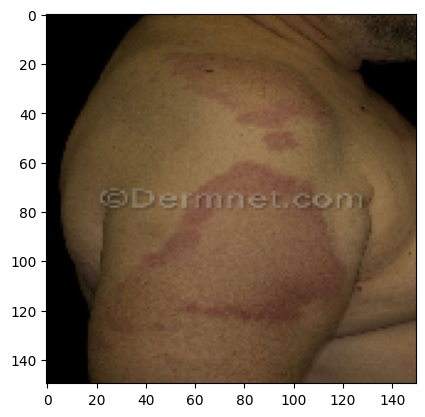

In [89]:
# Get image that want to predict
path = "/content/dermnet-image-for-train/test/urticaria-hives/erythema-annulare-centrifugum-15.jpg"
print(predict_skin_desease(path, new_model ,skin_type_desease))